In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# libraries

import cv2
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

sns.set(rc={'figure.figsize':(11.7,8.27)})


In [3]:
# training features

train = pd.read_csv('../input/train.csv')
train_results = []

for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    img = cv2.imread('../input//train_images/{}.png'.format(row['id_code']))

    height, width, channels = img.shape
    ratio = width/height
    pixel_count = width*height
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    black_cnt = pixel_count-cv2.countNonZero(gray_scaled)
    black_pct = black_cnt/pixel_count
    mean0, mean1, mean2, _ = cv2.mean(img)

    observation = np.array(
        (row['diagnosis'], height, width, ratio, pixel_count, black_cnt, black_pct, mean0, mean1, mean2))

    train_results.append(observation)

train_results_df = pd.DataFrame(train_results)
train_results_df.columns = [
    'diagnosis','height','width','ratio','pixel_count','black_cnt','black_pct','mean_c0','mean_c1','mean_c2']


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3295 [00:00<?, ?it/s]

In [4]:
# test features

test = pd.read_csv('../input/test.csv')
test_results = []

for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    img = cv2.imread('../input//test_images/{}.png'.format(row['id_code']))

    height, width, channels = img.shape
    ratio = width/height
    pixel_count = width*height
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    black_cnt = pixel_count-cv2.countNonZero(gray_scaled)
    black_pct = black_cnt/pixel_count
    mean0, mean1, mean2, _ = cv2.mean(img)

    observation = np.array(
        (np.nan, height, width, ratio, pixel_count, black_cnt, black_pct, mean0, mean1, mean2))

    test_results.append(observation)

test_results_df = pd.DataFrame(test_results)
test_results_df.columns = [
    'diagnosis','height','width','ratio','pixel_count','black_cnt','black_pct','mean_c0','mean_c1','mean_c2']


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/367 [00:00<?, ?it/s]

In [5]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'eta': 0.005,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'tree_method': 'gpu_hist',
    'num_class': 5}


In [6]:
X = train_results_df.drop(columns=['diagnosis'])
y = train_results_df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100000,
    evals=watchlist,
    early_stopping_rounds=250,
    verbose_eval=100
)


[00:13:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[00:13:12] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


XGBoostError: [00:13:12] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [00:13:12] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7ff4560f4f2a]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7ff45610b95a]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7ff4561153cd]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7ff455a2dc79]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7ff455a2ed09]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7ff455a924f7]
  [bt] (6) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7ff45572eef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7ff59673ae2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7ff596737493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7ff4560f4f2a]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7ff4561155c9]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7ff455a2dc79]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7ff455a2ed09]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7ff455a924f7]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7ff45572eef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7ff59673ae2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7ff596737493]
  [bt] (8) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x7ff5971024d8]



In [7]:
pred = pd.DataFrame(np.argmax(bst.predict(dvalid), axis=1))
results = pd.concat([y_test.reset_index(drop=True), pred], axis=1)
score = cohen_kappa_score(results.iloc[:,0], results.iloc[:,1], weights="quadratic")

print('Validation Kappa:', score)


NameError: name 'bst' is not defined

In [8]:
cm = confusion_matrix(y_true=results.iloc[:,0], y_pred=results.iloc[:,1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True)
ax.set(ylabel='True label', xlabel='Predicted label')


NameError: name 'results' is not defined

In [9]:
train['diagnosis'].value_counts()/train.shape[0]


diagnosis
0    0.494082
2    0.271927
1    0.103187
4    0.077390
3    0.053414
Name: count, dtype: float64

NameError: name 'bst' is not defined

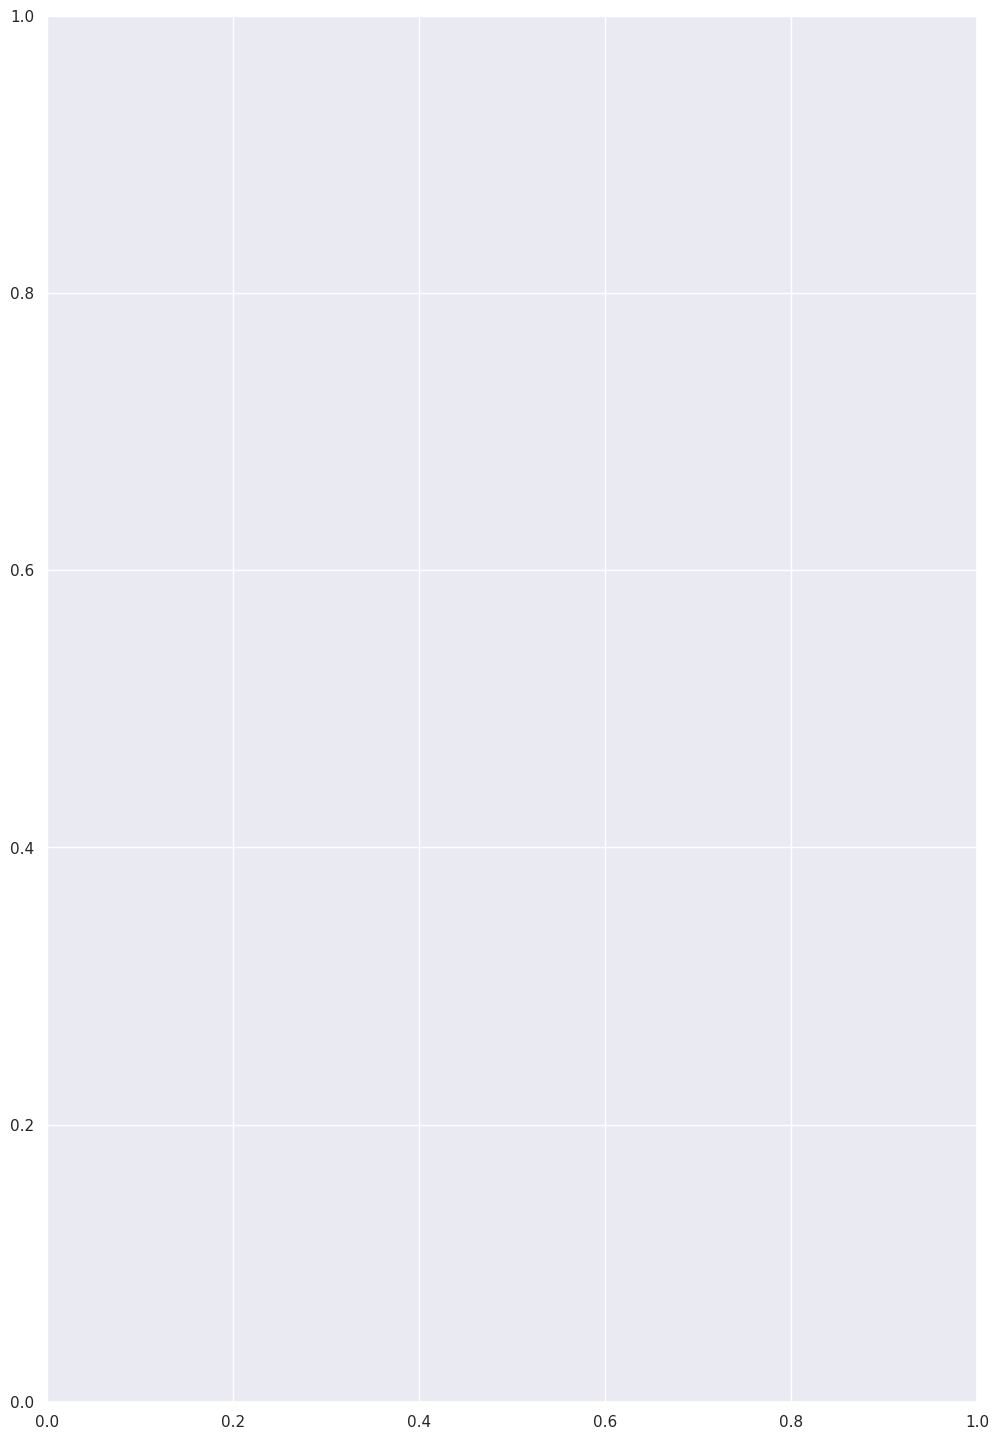

In [10]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, importance_type='gain', height=0.8, ax=ax)


In [11]:
train_results_df.groupby(['ratio', 'diagnosis'])['pixel_count'].count()


ratio     diagnosis
1.000000  0.0          819
          1.0           18
          2.0           34
          3.0            2
          4.0           13
1.216553  3.0            1
1.309119  1.0           12
          2.0           83
          3.0            6
          4.0           24
1.321397  0.0            9
          3.0            2
          4.0            1
1.321622  2.0            2
1.321757  0.0          207
          1.0           41
          2.0          145
          3.0           43
          4.0           40
1.324022  2.0            1
          4.0            1
1.333333  0.0          309
          2.0           29
          3.0            5
          4.0            3
1.333876  0.0          254
          1.0            7
          2.0            1
1.391705  0.0           28
          1.0          215
          2.0          210
          3.0           53
          4.0           67
1.489712  1.0            6
          2.0            3
          3.0           20
        

(-0.5, 4287.5, 2847.5, -0.5)

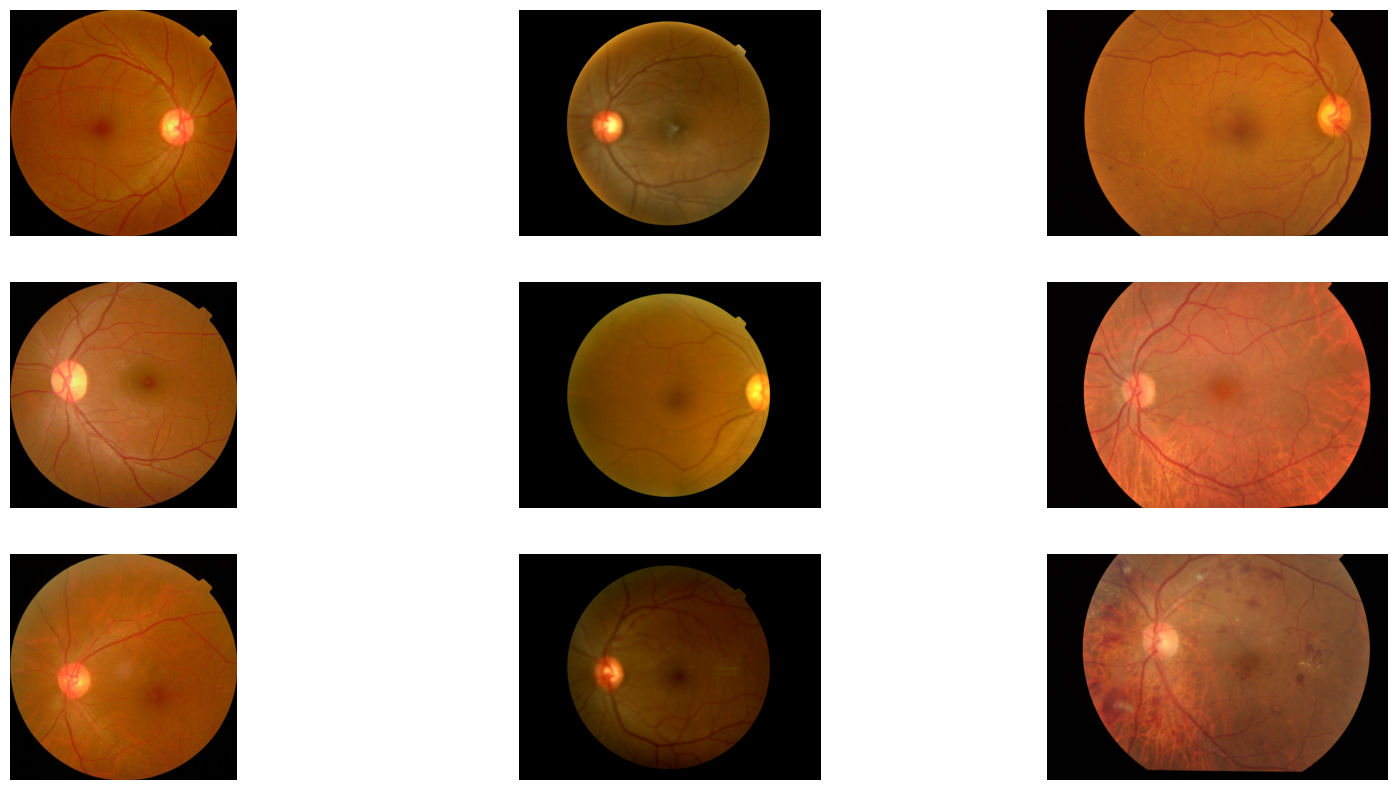

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))

img0a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[0], 0]))

ax[0,0].imshow(cv2.cvtColor(img0a, cv2.COLOR_BGR2RGB))
ax[0,0].axis('off')

img0b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[1], 0]))

ax[1,0].imshow(cv2.cvtColor(img0b, cv2.COLOR_BGR2RGB))
ax[1,0].axis('off')

img0c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[2], 0]))

ax[2,0].imshow(cv2.cvtColor(img0c, cv2.COLOR_BGR2RGB))
ax[2,0].axis('off')

img1a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[0], 0]))

ax[0,1].imshow(cv2.cvtColor(img1a, cv2.COLOR_BGR2RGB))
ax[0,1].axis('off')

img1b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[1], 0]))

ax[1,1].imshow(cv2.cvtColor(img1b, cv2.COLOR_BGR2RGB))
ax[1,1].axis('off')

img1c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[2], 0]))

ax[2,1].imshow(cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB))
ax[2,1].axis('off')

img2a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[0], 0]))

ax[0,2].imshow(cv2.cvtColor(img2a, cv2.COLOR_BGR2RGB))
ax[0,2].axis('off')

img2b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[1], 0]))

ax[1,2].imshow(cv2.cvtColor(img2b, cv2.COLOR_BGR2RGB))
ax[1,2].axis('off')

img2c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[2], 0]))

ax[2,2].imshow(cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB))
ax[2,2].axis('off')


(-0.5, 223.5, 223.5, -0.5)

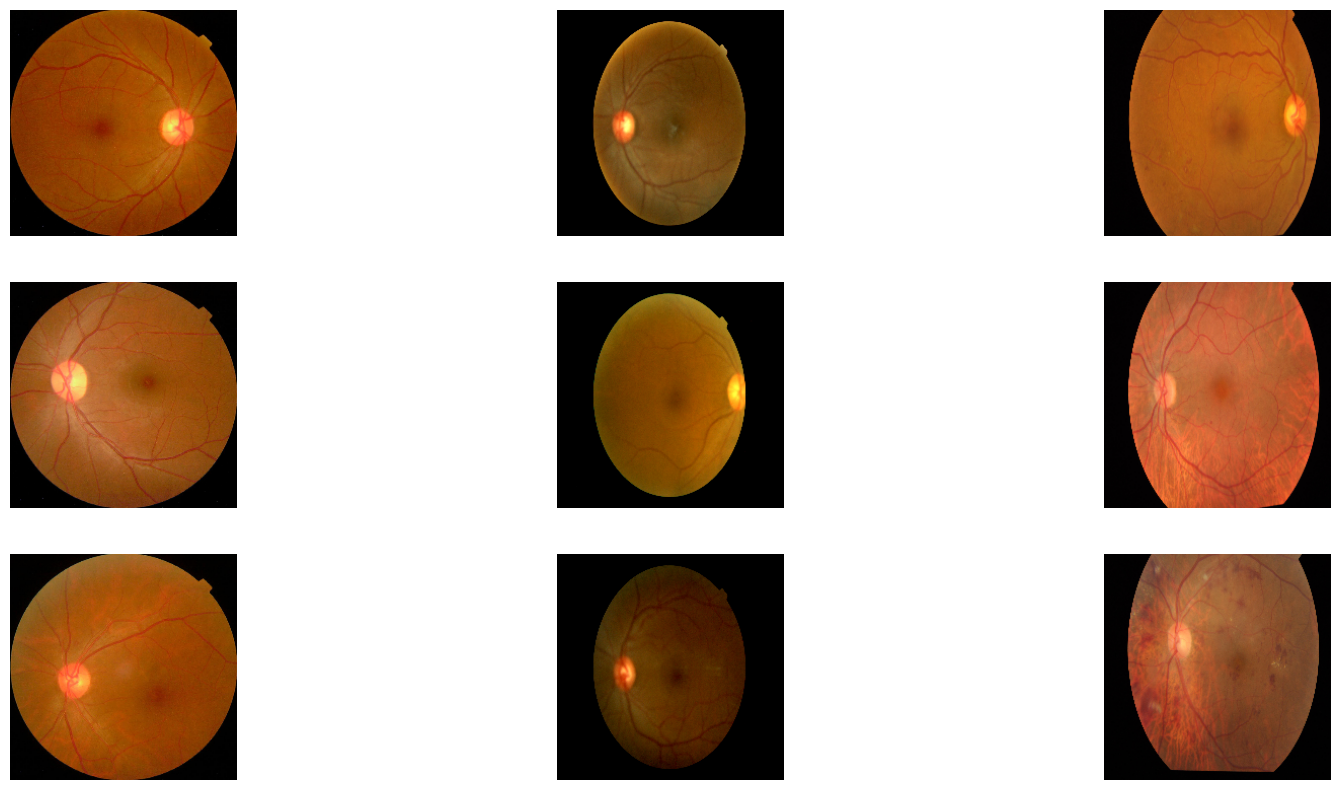

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))

img0a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[0], 0]))
img0a = cv2.resize(img0a, (224,224))
ax[0,0].imshow(cv2.cvtColor(img0a, cv2.COLOR_BGR2RGB))
ax[0,0].axis('off')

img0b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[1], 0]))
img0b = cv2.resize(img0b, (224,224))
ax[1,0].imshow(cv2.cvtColor(img0b, cv2.COLOR_BGR2RGB))
ax[1,0].axis('off')

img0c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[2], 0]))
img0c = cv2.resize(img0c, (224,224))
ax[2,0].imshow(cv2.cvtColor(img0c, cv2.COLOR_BGR2RGB))
ax[2,0].axis('off')

img1a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[0], 0]))
img1a = cv2.resize(img1a, (224,224))
ax[0,1].imshow(cv2.cvtColor(img1a, cv2.COLOR_BGR2RGB))
ax[0,1].axis('off')

img1b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[1], 0]))
img1b = cv2.resize(img1b, (224,224))
ax[1,1].imshow(cv2.cvtColor(img1b, cv2.COLOR_BGR2RGB))
ax[1,1].axis('off')

img1c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[2], 0]))
img1c = cv2.resize(img1c, (224,224))
ax[2,1].imshow(cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB))
ax[2,1].axis('off')

img2a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[0], 0]))
img2a = cv2.resize(img2a, (224,224))
ax[0,2].imshow(cv2.cvtColor(img2a, cv2.COLOR_BGR2RGB))
ax[0,2].axis('off')

img2b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[1], 0]))
img2b = cv2.resize(img2b, (224,224))
ax[1,2].imshow(cv2.cvtColor(img2b, cv2.COLOR_BGR2RGB))
ax[1,2].axis('off')

img2c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[2], 0]))
img2c = cv2.resize(img2c, (224,224))
ax[2,2].imshow(cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB))
ax[2,2].axis('off')


In [14]:
dtest = xgb.DMatrix(test_results_df.drop(columns=['diagnosis']))
test_pred = pd.DataFrame(np.argmax(bst.predict(dtest), axis=1))
submission = pd.concat([test['id_code'], test_pred], axis=1)
submission.columns = ['id_code','diagnosis']
submission.to_csv('submission.csv', index=False)
submission.head()


NameError: name 'bst' is not defined